# Exercise 8 - Python: Anomaly Detection and Recommender Systems

<img width="350px" src="https://upload.wikimedia.org/wikipedia/commons/0/07/Two-dimensional_Outliers_Example.png">

## *Part I*: Anomaly Detection

In this section, we will determine outliers in a dataset by using a statistical approach.  Specifically, we will assume that our variables have a [Gaussian (or normal) distribution](https://en.wikipedia.org/wiki/Normal_distribution), calculate the [probability density function (PDF)](https://en.wikipedia.org/wiki/Probability_density_function) to see the relative likelihood of  that point appearing (the actual definition is a lot more nuanced since the probability of any actual point will always be 0, but that's statistics for you), and then select the cutoff value that maximizes the [F1 score](https://en.wikipedia.org/wiki/F1_score) using a validation dataset.  We will then mark any point with a probability less than our cutoff value as an outlier.

This is technically a supervised approach since we're using labeled data and a validation set, but there are a plethora of unsupervised techniques as well.  Here are a few others for example:

- **Distance/Density based approaches:** [Local outlier factor](https://en.wikipedia.org/wiki/Local_outlier_factor), [clustering](https://en.wikipedia.org/wiki/Cluster_analysis), or [k-means](https://en.wikipedia.org/wiki/K-means_clustering)

- **Statistical approaches:** [Tukey's range test](https://en.wikipedia.org/wiki/Tukey%27s_range_test), [generalized extreme Studentized deviate (GESD)](http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm), and others

We're also using the words "anomaly" and "outlier" interchangeably, but there is often debate between the terms.  Generally speaking, an outlier is a value that is extremely unlikely (an improbability), and an anomaly is an invalid value (or impossibility) that was generated by a different process altogether (which goes back into statistical theory and the importance of the data generation process).  Regardless, we're going to continue using these two terms as synonyms because we are only concerned with detecting them rather than debating their validity.

---

Beginning with package imports and data loading

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio  # Used to load the Octave/MATLAB *.mat files
from scipy.stats import norm  # For estimating Gaussian probabilities
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

In [2]:
# Loading in the data from the matrix format using scipy
data = sio.loadmat('ex8/ex8data1.mat')

# Assigning to variables
X = data['X']
Xval = data['Xval']
yval = data['yval']

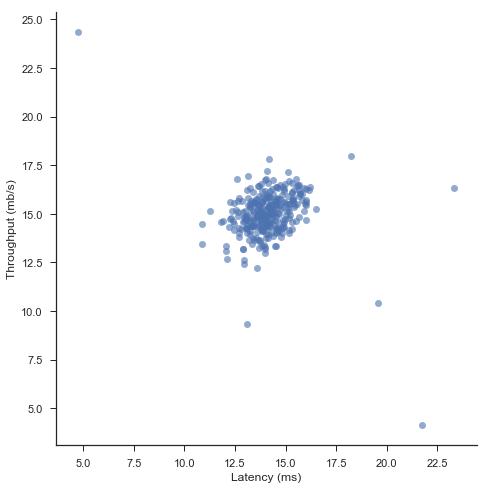

In [3]:
# Creating a data frame for plotting
df = pd.DataFrame(X, columns=['Latency (ms)', 'Throughput (mb/s)'])

# Plotting the original dataset
sns.lmplot(x='Latency (ms)', y='Throughput (mb/s)', data=df,
           fit_reg=False, size=7, scatter_kws={'alpha':0.6});

### Gaussian Distribution

Before performing anomaly detecting, we need to fit a model to the data's distribution.

Estimate the Gaussian distribution for each of the features $x_i$.  For each feature $i=1 \dots n$, find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, \dots, x_i^{(m)}\}$ (the $i$-th dimension of each example)

The Gaussian distribution is given by
$$p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} e ^ {-\frac{(x - \mu)^2}{2 \sigma^2}}
\\
\mu: \text{Mean}
\\
\sigma^2: \text{Controls the variance}$$

### Estimating Gaussian parameters

In order to estimate the parameters $(\mu_i, \sigma_i^2)$, of the $i$-th feature, we will use the following equations for the mean and variance:

$$\text{Mean: } \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}
\\
\text{Variance: } \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [4]:
def estimate_gaussian(X):
    """
    Takes the matrix X as an input and outputs:
    
    mu: n-dimension vector that holds the mean of all the n features
    sigma2: n-dimension vector that holds the variance of all features
    """
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    
    return mu, sigma2


mu, sigma2 = estimate_gaussian(X)

print('Mean:\n', mu,
      '\nVariance:\n', sigma2)

# Utilizing scipy to gather the PDF of the distribution
distribution = norm(mu[0], sigma2[0])

Mean:
 [ 14.11222578  14.99771051] 
Variance:
 [ 1.83263141  1.70974533]


Next, we'll plot the contour plot using our obtained mean and variance values

I borrowed some code from [kaleko's notebook](https://github.com/kaleko/CourseraML/blob/master/ex8/ex8.ipynb) in order to generate the contour plot (if you're reading this, thank you!)

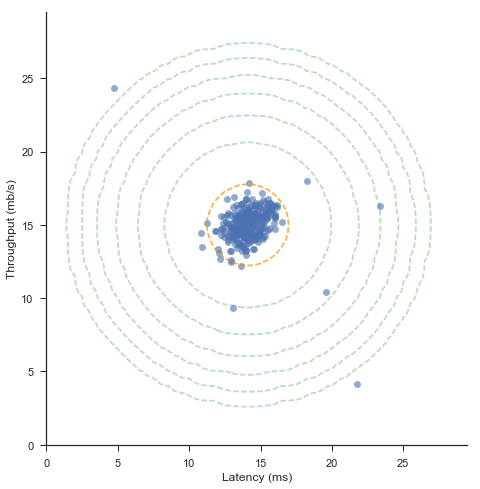

In [5]:
# Plotting the original data
sns.lmplot(
    x='Latency (ms)',
    y='Throughput (mb/s)',
    data=df,
    fit_reg=False,
    size=7,
    scatter_kws={'alpha': 0.6})


def gaus(myX, mymu, mysig2):
    """
    Function to compute the gaussian return values for a feature
    matrix, myX, given the already computed mu vector and sigma matrix.
    If sigma is a vector, it is turned into a diagonal matrix
    """
    m = myX.shape[0]
    n = myX.shape[1]
    if np.ndim(mysig2) == 1:
        mysig2 = np.diag(mysig2)

    norm = 1. / (np.power((2 * np.pi), n / 2) * np.sqrt(np.linalg.det(mysig2)))
    myinv = np.linalg.inv(mysig2)
    myexp = np.zeros((m, 1))
    for irow in range(m):
        xrow = myX[irow]
        myexp[irow] = np.exp(-0.5 * (
            (xrow - mymu).T).dot(myinv).dot(xrow - mymu))
    return norm * myexp


def plot_contour(mu, sigma, delta=0.5):
    """
    Plots the Gaussian distribution contour and cutoff point
    """
    # Creating the meshgrid to (insert why here)
    dim = np.arange(0, 30, delta)
    dx, dy = np.meshgrid(dim, dim)
    coord_list = [x.ravel() for x in (dx, dy)]
    points = np.vstack(coord_list).T
    
    # Converting into a Gaussian distribution
    Z = gaus(points, mu, sigma2)
    Z = Z.reshape((dx.shape[0], dx.shape[0]))
    cont_levels = [10**exp for exp in range(-20, 0, 3)]

    # Plotting the Gaussian contour plots
    # Using orange for the boundary for outliers, and green for the rest
    plt.contour(dx, dy, Z, levels=[cont_levels[-1]], linestyles='dashed',
                colors='darkorange', alpha=0.7)
    plt.contour(dx, dy, Z, levels=cont_levels[:-1], linestyles='dashed',
                colors='forestgreen', alpha=0.3)


plot_contour(mu, sigma2)

### Selecting the threshold $\epsilon$

With the Gaussian parameters, we can see which points are more or less likely to be outliers according to their probabilities in the distribution.  We can determine the threshold for outliers with the cross validation set.

We'll do this by optimizing the $F_1$ score on the cross validation set.  As a reminder, the $F_1$ score is a mix of precision and recall:

$$F_1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$

and precision and recall are calculated as follows:

$$precision = \frac{True Positive}{True Positive + False Positive}
\\
recall = \frac{True Positive}{True Positive + False Negative}$$

In [6]:
def select_threshold(Xval, yval, distribution):
    """
    Selects the threshold for determining outliers according to which minimizes
    our F1 score on the validation set
    
    Returns the threshold and the F1 score
    """
    # Creating variables to be replaced
    optimalEpsilon = 0
    optimalF1 = 0

    # Generating the probability of the point according to the distribution
    probability = distribution.pdf(Xval)

    # Setting the size of steps for trying different values of epsilon
    stepSize = probability.max() / 1000

    # Looping through values of epsilon to find the optimal value
    for epsilon in np.arange(probability.min() + stepSize,
                             probability.max(), stepSize):
        prediction = probability < epsilon

        # Calculating true/false positives/negatives
        truePositive = np.sum(np.logical_and(prediction == 1, yval == 1))
        falsePositive = np.sum(np.logical_and(prediction == 1, yval == 0))
        falseNegative = np.sum(np.logical_and(prediction == 0, yval == 1))

        # Calculating the F1 score
        precision = truePositive / (truePositive + falsePositive)
        recall = truePositive / (truePositive + falseNegative)
        f1 = (2 * precision * recall) / (precision + recall)

        # Checks if current f1 is better, and replaced optimalF1 if so
        if f1 > optimalF1:
            optimalEpsilon = epsilon
            optimalF1 = f1

    return optimalEpsilon, optimalF1


results = select_threshold(Xval, yval, distribution)

print('Epsilon (cutoff):', results[0],
      '\nF1 Score:', results[1])

Epsilon (cutoff): 0.0376600629603 
F1 Score: 0.689655172414


Now that we have our cutoff, let's assign it to our data set and plot the results

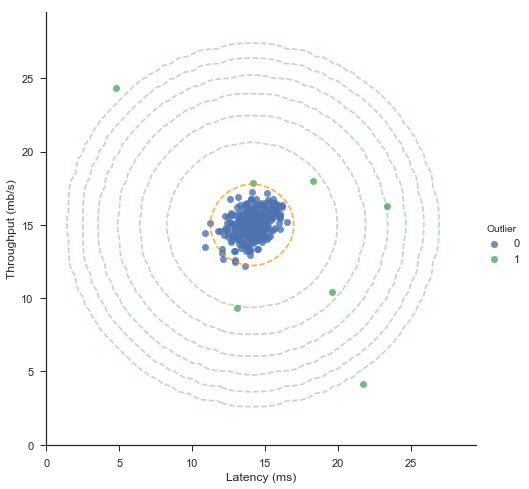

In [7]:
# Calculating the probability density for the original data points
df['LatencyProb'] = norm(mu[0], sigma2[0]).pdf(df['Latency (ms)'])
df['ThroughputProb'] = norm(mu[0], sigma2[0]).pdf(df['Throughput (mb/s)'])

# Assigning outliers based on our obtained epsilon
df['Outlier'] = np.where(((df['LatencyProb'] < results[0]) |
                          (df['ThroughputProb'] < results[0])), 1, 0)

# Plotting the data with outliers
sns.lmplot(
    x='Latency (ms)',
    y='Throughput (mb/s)',
    hue='Outlier',
    data=df,
    fit_reg=False,
    size=7)

# Adding the contour plot
plot_contour(mu, sigma2)

While this color pallet isn't that great at displaying contrasts, we can see that most points outside of our initial level of the contour plot are considered outliers

### High dimensional dataset

This last section of part I does the same things on a dataset that is much more similar to a realistic scenario.  We won't be able to plot this without using a dimensionality reduction algorithm like [$t$-SNE](https://distill.pub/2016/misread-tsne/), but we can at least view our acquired $\epsilon$ and F1 score

In [8]:
# Importing the data
data = sio.loadmat('ex8/ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

# Calculating the parameters of the variables
mu, sigma2 = estimate_gaussian(X)
print('Mean:\n', mu,
      '\nVariance:\n', sigma2)

# Utilizing scipy to gather the PDF of the distribution
distribution = norm(mu[0], sigma2[0])

# Calculating the cutoff and F1 score
results = select_threshold(Xval, yval, distribution)
print('\nEpsilon (cutoff):', results[0],
      '\nF1 Score:', results[1])

Mean:
 [  4.93940034  -9.63726819  13.81470749 -10.4644888   -7.95622922
  10.19950372  -6.01940755   7.96982896  -6.2531819    2.32451289
   8.47372252] 
Variance:
 [ 60.97489373  53.20572186  58.51546272  84.20403725  65.26859177
  89.57487757  55.63349911  87.16233783  29.62926829  70.7852052
  50.50356719]

Epsilon (cutoff): 0.00640501131254 
F1 Score: 0.231404958678


---

## *Part II*: Recommender Systems

**[Explain section here]**

### Moving ratings dataset

I attended the University of Minnesota for grad school, and they are responsible for curating an extremely popular dataset for recommender systems: [MovieLens](https://en.wikipedia.org/wiki/MovieLens).  *Every single professor* talked about it, and I had to sit through countless presentations of student groups using it for projects.  I thought I was finally done with movie ratings and recommender systems, but here we go again.

We have a few things going on with the data we're reading in here:

- **X:** A matrix of features for the movies (ex. genre, actors, directors, etc.).  Each row is a movie, and each column is a feature.  

- **Y:** A matrix of the ratings users provided for movies.  Each row is a user, each column is a movie, and each value is the rating.

- **R:** A matrix of binary flags for if a user provided a rating for a given movie.  This goes along with the Y matrix since we aren't using null values.  Additionally, we want to predict the ratings that users will give the movies they haven't yet rated.

- **$\Theta$:** A matrix of weights provided for the features in X.



$n_u$ = 943 users

$n_m$ = 1682 movies

X = $n_m \times 100$ matrix

$\Theta$ = $n_u \times 100$ matrix

In [9]:
# Loading in the ratings
data = sio.loadmat('ex8/ex8_movies.mat')
R = data['R']
y = data['Y']

# Loading in the features
data = sio.loadmat('ex8/ex8_movieParams.mat')
theta = data['Theta']
X = data['X']

print('R & y:', R.shape)
print('X & Theta:', X.shape)

R & y: (1682, 943)
X & Theta: (1682, 10)


The Octave code provided for this exercise plots the y variable to view the distribution of ratings:

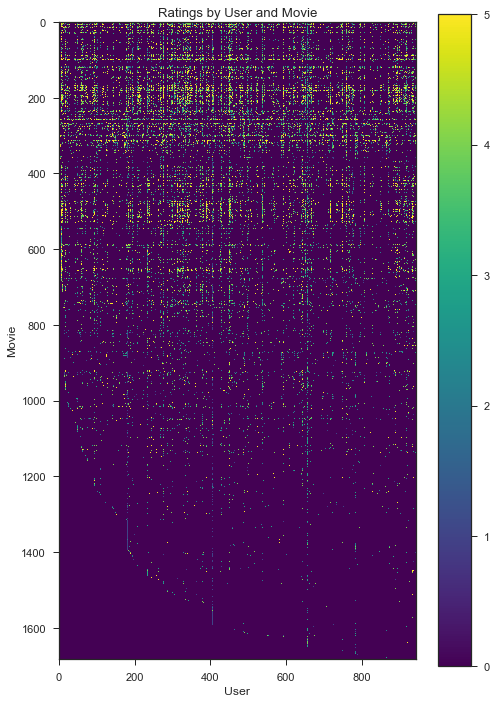

In [10]:
fig, ax = plt.subplots(figsize=(8, 12))

ratings = plt.imshow(y, cmap='viridis')
fig.colorbar(ratings)

ax.set_xlabel('User')
ax.set_ylabel('Movie')
plt.title('Ratings by User and Movie');

### Collaborative Filtering

**[Talk about collaborative filtering here]**

Before we can learn the parameter vectors that produce the best fit (minimize the squared error), we need to compute the cost function and the gradient for collaborative filtering.  

Additionally, we're running into the same issue as exercise 4 where SciPy's optimize function doesn't accept multidimensional parameters, so we have to provide our parameters as a vector to our functions.  However, this has to be a *single* vector, so we have to provide our multiple parameters as one into our cost and gradient function.

In order to assist with this, we'll create a few helper functions to flatten and reshape our parameters.

In [11]:
def flatten_params(X, theta):
    """
    Prepares parameters for input into cost and gradient functions
    """
    return np.concatenate([X.ravel(), theta.ravel()])


def reconstruct_params(parameters, X, Y):
    """
    Recondstructs parameters into original shape for use within
    cost and gradient functions
    """    
    newTheta = np.reshape(parameters[Y.shape[0] * X.shape[1]:],
                                    (Y.shape[1], X.shape[1]))
    newX = np.reshape(parameters[:Y.shape[0] * X.shape[1]],
                                (Y.shape[0], X.shape[1]))
    
    return newTheta, newX

#### Collaborative Filtering Cost Function

$$J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)}) = \frac{1}{2} \sum_{(i, j):r(i, j) = 1} (\theta^{(j)})^T x^{(i)} -y^{(i, j)})^2$$

As a reminder, the subtext of the summation symbol is telling us to only calculate the cost if the user has rated the movie.

According to the exercise, our cost should be around 22.22.

In [12]:
def cost_function(parameters, X, y, R):
    """
    Calculates the unregularized cost function for collaborative filtering
    """
    # Restructuring into the original shapes
    theta, X = reconstruct_params(parameters, X, y)
    
    # Calculating the cost
    error = (np.dot(X, theta.T) * R) - y  # Accounts for unrated movies
    squaredError = np.power(error, 2)
    cost = (1 / 2) * np.sum(squaredError)
    return cost


# Reducing the data for testing this function per exercise instructions
# This is to reduce the overall computations needed
num_users = 4
num_movies = 5
num_features = 3

X = X[:num_movies, :num_features]
theta = theta[:num_users, :num_features]
y = y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

cost_function(flatten_params(X, theta), X, y, R)

22.224603725685675

#### Collaborative Filtering Gradient

$$\frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i, j) = 1} ((\theta^{(j)})^T x^{(i)} - y^{(i, j)})\theta_k^{(j)}
\\
\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i, j) = 1} ((\theta^{(j)})^T x^{(i)} - y^{(i, j)})x_k^{(i)}$$

In [13]:
def gradient(parameters, X, y, R):
    """
    Calculates the unregularized gradient for collaborative filtering
    """
    # Restructuring into the original shapes
    theta, X = reconstruct_params(parameters, X, y)
    
    # Calculating the error for the gradients
    error = (np.dot(X, theta.T) * R) - y
    
    # Calculating the gradients
    xGradient = np.dot(error, theta)
    thetaGradient = np.dot(error.T, X)
    return xGradient, thetaGradient


gradient(flatten_params(X, theta), X, y, R)

(array([[-2.52899165,  7.57570308, -1.89979026],
        [-0.56819597,  3.35265031, -0.52339845],
        [-0.83240713,  4.91163297, -0.76677878],
        [-0.38358278,  2.26333698, -0.35334048],
        [-0.80378006,  4.74271842, -0.74040871]]),
 array([[-10.5680202 ,   4.62776019,  -7.16004443],
        [ -3.05099006,   1.16441367,  -3.47410789],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ]]))

#### Regularized Cost Function

$$J(x^{(1)}, ..., x^{(n_m)}, \theta^{(1)}, ..., \theta^{(n_u)}) = \frac{1}{2} \sum_{(i, j):r(i, j) = 1} (\theta^{(j)})^T x^{(i)} -y^{(i, j)})^2 +
\Big( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n (\theta_k^{(j)})^2 \Big) +
\Big( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n (x_k^{(i)})^2 \Big)$$

According to the exercise, our cost should be around 31.34.

In [14]:
def cost_function(parameters, X, y, R, C=0):
    """
    Calculates the regularized cost function for collaborative filtering
    """
    # Restructuring into the original shapes
    theta, X = reconstruct_params(parameters, X, y)
    
    # Calculating the cost
    error = (np.dot(X, theta.T) * R) - y  # Accounts for unrated movies
    squaredError = np.power(error, 2)
    cost = (1 / 2) * np.sum(squaredError)
    
    # Calculating the regularization terms
    regTheta = (C/2) * np.sum(np.power(theta, 2))
    regX = (C/2) * np.sum(np.power(X, 2))
    
    return cost + regX + regTheta


cost_function(flatten_params(X, theta), X, y, R, 1.5)

31.344056244274217

#### Regularized Gradient

$$\frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i, j) = 1} ((\theta^{(j)})^T x^{(i)} - y^{(i, j)})\theta_k^{(j)} + \lambda x_k^{(i)}
\\
\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i, j) = 1} ((\theta^{(j)})^T x^{(i)} - y^{(i, j)})x_k^{(i)} + \lambda \theta_k^{(j)}$$

In [15]:
def gradient(parameters, X, y, R, C=0):
    """
    Calculates the regularized gradient for collaborative filtering
    """
    # Restructuring into the original shapes
    theta, X = reconstruct_params(parameters, X, y)
    
    # Calculating the error for the gradients
    error = (np.dot(X, theta.T) * R) - y
    
    # Calculating the gradients and regularization terms
    xGradient = np.dot(error, theta) + (C * X)
    thetaGradient = np.dot(error.T, X) + (C * theta)
    
    # Flattening for optimization function
    return flatten_params(xGradient, thetaGradient)


gradient(flatten_params(X, theta), X, y, R, 1.5)

array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
         2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
        -0.89247334,   0.29684395,   1.06300933,   0.66738144,
         0.60252677,   4.90185327,  -0.19747928, -10.13985478,
         2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
        -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
         1.09289758,  -0.40784086,   0.49026541])

### Learning Movie Recommendations

In [16]:
# Re-loading the full dataset
data = sio.loadmat('ex8/ex8_movies.mat')
R = data['R']
y = data['Y']
data = sio.loadmat('ex8/ex8_movieParams.mat')
theta = data['Theta']
X = data['X']

# Setting the initial parameters
initialParams = np.random.random(flatten_params(X, theta).shape)

# Finding the optimal values for X and Theta
optimalParams = optimize.fmin_cg(cost_function,  # Function to minimize
                                 fprime=gradient,  
                                 x0=initialParams,  # Initial guess
                                 args=(X, y, R, 10),  # Additional Arguments
                                 maxiter=50,
                                 disp=False)  # Removes unnecessary text

optimalX, optimalTheta = reconstruct_params(optimalParams, X, y)
print('Optimal X:\n', optimalX, '\n\nOptimal Theta:\n', optimalTheta)

Optimal X:
 [[ 0.53333935  0.81053346  1.07448067 ...,  0.67890352 -0.06192768
   0.78007592]
 [ 0.7105954   0.45402066  0.53172201 ...,  0.40140253  0.79906254
   0.97703259]
 [ 0.03411233  0.76331144  0.06081465 ...,  0.6607469   0.56245852
   0.69542682]
 ..., 
 [ 0.58034034  0.42769968  0.78986354 ...,  0.68850172  0.65894359
   0.41663416]
 [ 0.97360728  0.81395193  0.83842768 ...,  0.57002536  0.73882618
   0.80368296]
 [-0.23721632  0.6153814   0.16036034 ...,  0.72690634  1.30771424
   0.30535072]] 

Optimal Theta:
 [[ 0.71607796  0.51980233  0.87595065 ...,  1.02735338  1.09699014
   0.25541999]
 [ 0.647153    0.75029234  0.42124593 ...,  0.7607479   0.59157659
   0.15056921]
 [ 0.16427405  0.9773441   0.76913086 ...,  0.6314372   0.12045585
   0.09750356]
 ..., 
 [ 0.05785535  0.04779463  0.07698034 ...,  0.13185775  0.11801871
   0.04853099]
 [ 0.10621696  0.08355773  0.2303209  ...,  0.03234773  0.22597986
   0.11712737]
 [ 0.0858329   0.11773735  0.12285139 ...,  0.0512379